run with `popstrucure` env

In [99]:
import os
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import glob
import numpy as np
import pandas as pd
import scipy.stats as stats
import geopandas as gpd
import rasterio
from rasterio.plot import show
import seaborn as sns

In [9]:
proj_dir="/master/nplatt/sch_hae_its-nigeria"
results_dir="{}/results".format(proj_dir)

os.chdir(proj_dir)

In [128]:
#you can get this table from the SCAN dryad link
info_df=pd.read_csv(f"{proj_dir}/its-nigeria_samplesheet.csv", sep=",")
info_df

,wgs_id,its_id,sra,species,country,locale,patient,miracidum
0,Sb_NG_ak_1.1,Sb.ng.ak.1.1F,NaN,sbovis,nigeria,ak,1,1
1,Sb_NG_ak_2.1,sb_ng_ak_2.1,NaN,sbovis,nigeria,ak,2,1
2,Sb_NG_ak_2.2,Sb.ng.ak.2.2F,NaN,sbovis,nigeria,ak,2,2
3,Sb_NG_ak_2.3,Sb.ng.ak.2.3F,NaN,sbovis,nigeria,ak,2,3
4,Sb_NG_ak_3.1,Sb.ng.ak.3.1R,NaN,sbovis,nigeria,ak,3,1
...,...,...,...,...,...,...,...,...
200,Sh_NG_os_3_1,sh_ng_os_3_1,NaN,shaematobium,nigeria,osun,3,1
201,c_Sh_NG_os_3_11,Sh.ng.os.3.11F,NaN,shaematobium,nigeria,osun,3,11
202,c_Sh_NG_os_3_5,Sh.ng.os.3.5F,NaN,shaematobium,nigeria,osun,3,5
203,c_Sh_NG_os_3_6,Sh.ng.os.3.6F,NaN,shaematobium,nigeria,osun,3,6


# Unsupervised Admixture

In [60]:
Path(f"{results_dir}/unsupervised_admixture/logs").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/unsupervised_admixture")

In [27]:
%%bash 

conda run -n vcftools --cwd . --live-stream \
    vcftools \
        --vcf ../../results/filter_genotypes/SH_V3/snvs.ld.vcf \
        --keep ingroup.txt \
        --maf 0.05 \
        --thin 10000 \
        --recode \
        --recode-INFO-all \
        --stdout \
        >adm.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
./results/filter_genotypes/SH_V3/snvs.ld.vcf
	--keep ingroup.txt
	--recode-INFO-all
	--maf 0.05
hin 10000
	--recode
	--stdout

ted at least 2 parts in FORMAT entry: ID=PID,Number=1,Type=String,Description="Physical phasing ID information, where each unique ID within a given sample (but not across samples) connects records within a phasing group">
r,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">
e count in genotypes, for each ALT allele, in the same order as listed">teger,Description="Allel
2 parts in INFO entry: ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes, for each ALT allele, in the same order as listed">
mber=A,Type=Float,Description="Allele Frequency, for each ALT allele, in the same order as listed">
 entry: ID=MLEAC,Number=A,Type=Integer,Description="Maximum likelihood expectation (MLE) for the allele counts (not nec

In [28]:
%%bash

conda run -n plink \
    plink \
        --vcf adm.vcf \
        --out adm \
        --double-id \
        --recode12 \
        --allow-extra-chr

PLINK v1.9.0-b.7.7 64-bit (22 Oct 2024)            cog-genomics.org/plink/1.9/
urcell, Christopher Chang   GNU General Public License v3
recode 12 ...".2 flag deprecated.  Use "--
Logging to adm.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --out adm
  --recode 12
  --vcf adm.vcf

1031287 MB RAM detected; reserving 515643 MB for main workspace.

vcf: 1k variants complete.
--vcf: 2k variants complete.
--vcf: 3k variants complete.
nts complete.ia
--vcf: 5k variants complete.
--vcf: 6k variants complete.
--vcf: 7k variants complete.
--vcf: 8k variants complete.
--vcf: 9k variants complete.
--vcf: 10k variants complete.
variants complete.
--vcf: 12k variants complete.
--vcf: 13k variants complete.
omplete.4k variants c
--vcf: 15k variants complete.
--vcf: 16k variants complete.
--vcf: 17k variants complete.
-vcf: adm-temporary.bed + adm-temporary.bim + adm-temporary.fam written.
.bim file.ants loaded from 
200 people (0 males, 0 females, 200 ambiguous) loaded from .fam.
n to 

In [30]:
%%bash

# edit this to only include ingroup samples
conda run -n bcftools bcftools query -l ../pca/pca.vcf >samples.list

In [31]:
%%bash

#UNSUPERVISED 
#submit jobs to the cluster
QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y "  

for K in $(seq 1 20); do
    CMD="conda run -n admixture --cwd . --live-stream admixture \
        --cv=1000 \
        -j25 \
        adm.ped \
        $K \
        >adm_$K.log"

    echo $CMD | $QSUB -N adm_k$K -o logs/adm_k$K.log -pe smp 24
done

Your job 1659116 ("adm_k1") has been submitted
Your job 1659117 ("adm_k2") has been submitted
Your job 1659118 ("adm_k3") has been submitted
Your job 1659119 ("adm_k4") has been submitted
Your job 1659120 ("adm_k5") has been submitted
Your job 1659121 ("adm_k6") has been submitted
Your job 1659122 ("adm_k7") has been submitted
Your job 1659123 ("adm_k8") has been submitted
Your job 1659124 ("adm_k9") has been submitted
Your job 1659125 ("adm_k10") has been submitted
Your job 1659126 ("adm_k11") has been submitted
Your job 1659127 ("adm_k12") has been submitted
Your job 1659128 ("adm_k13") has been submitted
Your job 1659129 ("adm_k14") has been submitted
Your job 1659130 ("adm_k15") has been submitted
Your job 1659131 ("adm_k16") has been submitted
Your job 1659132 ("adm_k17") has been submitted
Your job 1659133 ("adm_k18") has been submitted
Your job 1659134 ("adm_k19") has been submitted
Your job 1659135 ("adm_k20") has been submitted


In [38]:
%%bash

#get CV scores when jobs are completed
echo "k,cv" >cv_table.csv
for i in $(seq 2 20); do 
    CV=$(grep "CV error" adm_$i.log | rev | cut -f1 -d" "| rev)
    echo "$i,$CV"
done >>cv_table.csv

In [39]:
cv_df=pd.read_csv("cv_table.csv", sep=",") 
cv_df

,k,cv
0,2,0.31795
1,3,0.30277
2,4,0.29996
3,5,0.24182
4,6,0.24007
5,7,0.24137
6,8,0.23981
7,9,0.23947
8,10,0.23964
9,11,0.24182


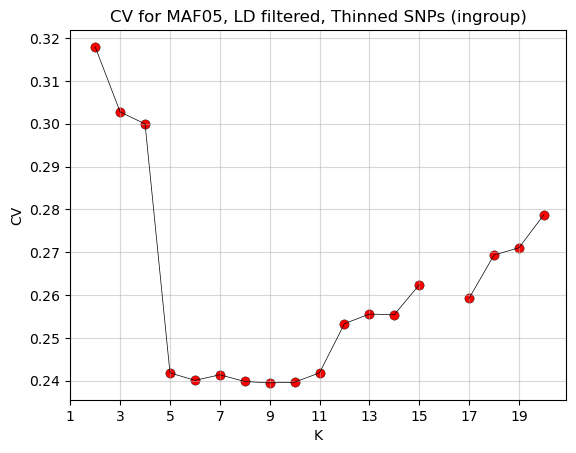

In [40]:
## #plot the cv_table
plt.plot(cv_df["k"], cv_df["cv"], color="black", linewidth=0.5)
plt.scatter(cv_df["k"], cv_df["cv"], 
            marker="o", 
            color="red", 
            edgecolor="black", 
            linewidths=0.3, 
            s=45)
#plt.ylim([0.35, 0.4])
plt.xticks(list(range(1,20, 2)))
plt.grid(alpha=0.5)
plt.title("CV for MAF05, LD filtered, Thinned SNPs (ingroup)")
plt.ylabel("CV")
plt.xlabel("K")
plt.savefig("cv.svg")
plt.savefig("cv.png", dpi=300)

plt.show()

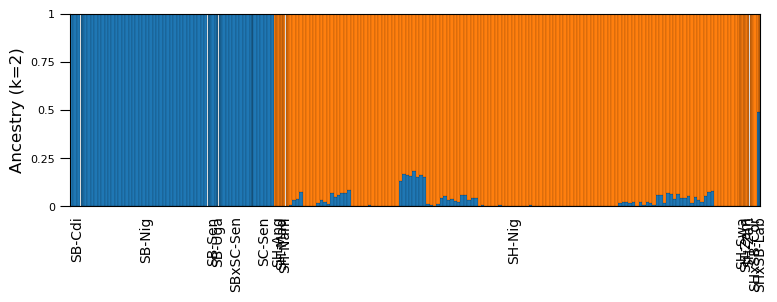

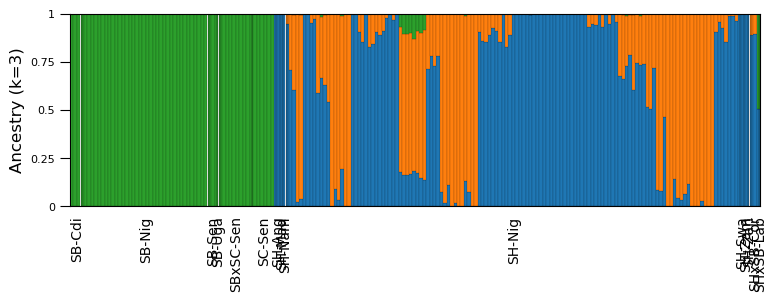

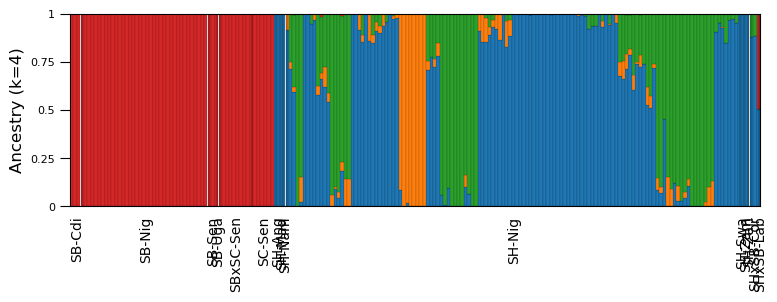

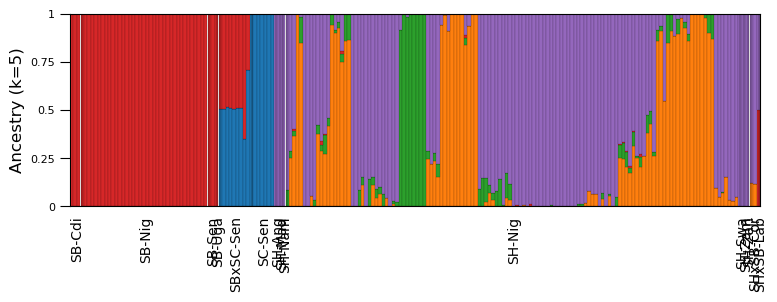

In [65]:
import matplotlib.pyplot as plt
import pandas as pd

cm = 1 / 2.54  # cm to inches
species_labels = {'sbovis':       "SB", 
                  'sbxsc':        "SBxSC", 
                  'scurassoni':   "SC", 
                  'shaematobium': "SH",
                  'shxsb':        "SHxSB"}

# Load sample list
samples = open("samples.list").read().splitlines()[:-1]

# Load metadata
info_df=pd.read_csv(f"{proj_dir}/its-nigeria_samplesheet.csv", sep=",")

# Set K values to plot
ks = list(range(2, 6))
gap_size = 0.1  # space between populations

for k in ks:
    figsize = (20 * cm, 8 * cm)
    # figsize = (20, 8)
    fig, ax = plt.subplots(figsize=figsize)

    # Load Q matrix and attach sample names
    adm_df = pd.read_csv(f"adm.{k}.Q", sep=" ", header=None)
    adm_df["wgs_id"] = samples

    # Merge with metadata and sort by group
    adm_df = adm_df.merge(info_df, how="left", on="wgs_id")
    adm_df = adm_df.sort_values(by=["species", "country"]).reset_index(drop=True)

    # Assign group labels
    group_labels = []
    group_positions = []
    group_ids = []
    prev_group = None
    group_idx = -1

    for i, row in adm_df.iterrows():
        species_abbr = species_labels[row["species"]]
        try:
            country_abbr = row["country"][:3].capitalize()
        except:
             country_abbr = "Unk"
        
        group = f"{species_abbr}-{country_abbr}"
        if group != prev_group:
            group_idx += 1
            group_labels.append(group)
            group_positions.append(i)
            prev_group = group
        group_ids.append(group_idx)

    # Compute new x positions with gaps
    sample_positions = []
    current_offset = 0
    prev_group_id = group_ids[0]

    for i, group_id in enumerate(group_ids):
        if i > 0 and group_id != prev_group_id:
            current_offset += gap_size
        sample_positions.append(current_offset)
        current_offset += 1
        prev_group_id = group_id

    # Plot stacked bars at new x positions
    bottom = [0] * len(adm_df)
    for p_comp in range(k):
        ax.bar(
            sample_positions,
            adm_df[p_comp],
            bottom=bottom,
            edgecolor="black",
            linewidth=0.1,
            width=1.0
        )
        bottom = [b + adm_df[p_comp].iloc[i] for i, b in enumerate(bottom)]

    # Add vertical lines and abbreviated group labels
    for i, label in enumerate(group_labels):
        start = sample_positions[group_positions[i]]
        end = sample_positions[group_positions[i + 1]] if i + 1 < len(group_positions) else sample_positions[-1] + 1
        center = (start + end) / 2
        if i > 0:
            ax.axvline(start - (gap_size / 2), color="black", linewidth=0.3)
        ax.text(center, -0.05, label, rotation=90, ha="center", va="top", fontsize=10, clip_on=False)

    # Aesthetic settings
    ax.set_ylabel(f"Ancestry (k={k})", fontsize=12)
    ax.set_xlim(-0.5, sample_positions[-1] + 0.5)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_yticklabels(["0", "0.25", "0.5", "0.75", "1"], fontsize=8)
    ax.tick_params(length=7, labelbottom=False)
    plt.tight_layout()

    # Save or show
    adm_df.to_csv(f"admix_k{k}.csv", header=True, index=False)
    plt.savefig(f"admix_k{k}.svg", bbox_inches="tight")
    plt.savefig(f"admix_k{k}.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
